# Classifying the Health Status of Foeti

Created by Joshua Yim Wei Xiang

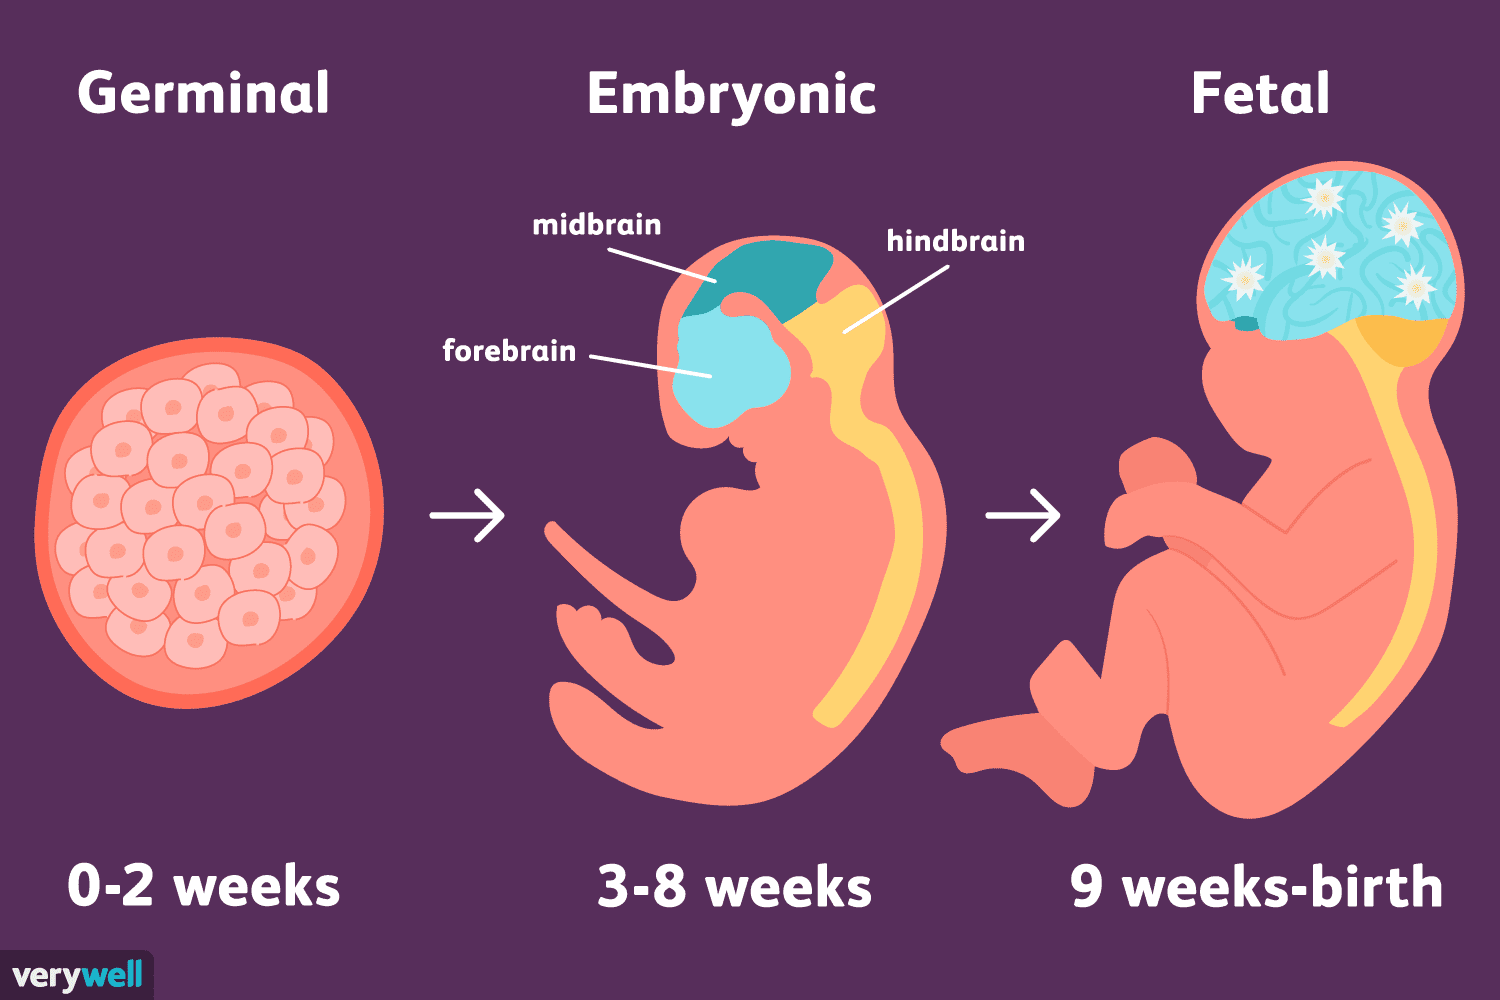

### Library Importing

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

### Fetal Health Dataframe 

In [4]:
fetal_health_df = pd.read_csv('fetal_health.csv')

def tendency(t):
    if t == 1.0: return 2.0
    elif t == 0.0: return 1.0
    else: return 0.0

fetal_health_df['hist_tendency'] = [tendency(t) for t in fetal_health_df.histogram_tendency]
fetal_health_df = fetal_health_df.drop(['histogram_tendency'], axis = 1)
fetal_health_df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,fetal_health,hist_tendency
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,2.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,1.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,1.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,2.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,2.0


### Data Exploration

Number of Foeti in each Category

1.0    1655
2.0     295
3.0     176
Name: fetal_health, dtype: int64



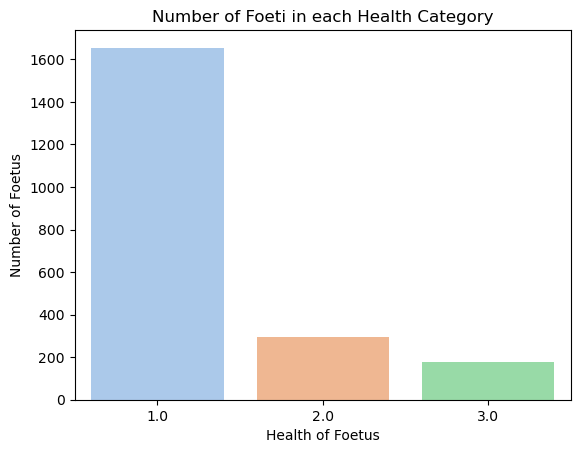

Percentage of Normal Foeti: 77.85%
Percentage of Foeti with Suspected Irregularities: 13.88%
Percentage of Foeti with necessary pathology procedures needed: 8.28%


In [5]:
classifier_count = fetal_health_df['fetal_health'].value_counts()
print('Number of Foeti in each Category')
print('')
print(classifier_count)
print('')
count_plot = sns.countplot(x = 'fetal_health', data = fetal_health_df, palette = 'pastel')
count_plot.set(xlabel = 'Health of Foetus', ylabel = 'Number of Foetus', title = 'Number of Foeti in each Health Category')
plt.show()

def percentage_calc(category_string):
    pct_1 = len(fetal_health_df[fetal_health_df['fetal_health'] == category_string[0]]) / len(fetal_health_df) * 100
    pct_2 = len(fetal_health_df[fetal_health_df['fetal_health'] == category_string[1]]) / len(fetal_health_df) * 100
    pct_3 = len(fetal_health_df[fetal_health_df['fetal_health'] == category_string[2]]) / len(fetal_health_df) * 100
    print(f'Percentage of Normal Foeti: {pct_1:.2f}%')
    print(f'Percentage of Foeti with Suspected Irregularities: {pct_2:.2f}%')
    print(f'Percentage of Foeti with necessary pathology procedures needed: {pct_3:.2f}%')
    
string = [1.0, 2.0, 3.0]    
percentage_calc(string)

#### It is obeserved that the classes are imbalanced with a ratio of 78:14:8, a resampling method will be carried out to have a balanced dataset

In [6]:
fetal_health_df.groupby('fetal_health').mean().iloc[:, :10]

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability
fetal_health,,,,,,,,,,
1.0,131.981873,0.003992,0.007963,0.004781,0.001941,6.042296e-07,0.000051,42.465861,1.430634,5.044713
2.0,141.684746,0.000275,0.008332,0.002390,0.000536,0.000000e+00,0.000095,61.901695,0.638983,29.030508
3.0,131.687500,0.000392,0.025676,0.003784,0.003670,3.409091e-05,0.001273,64.539773,1.575568,22.846591


In [7]:
fetal_health_df.groupby('fetal_health').mean().iloc[:, 11:]

,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,hist_tendency
fetal_health,,,,,,,,,,
1.0,73.400000,91.085801,164.485801,4.163142,0.335347,138.258610,135.102115,138.459819,17.479758,1.341994
2.0,49.159322,113.294915,162.454237,3.311864,0.244068,146.555932,144.759322,147.071186,7.213559,1.433898
3.0,78.346591,83.982955,162.329545,4.443182,0.346591,114.607955,112.977273,119.562500,50.732955,0.926136


###### Obeservations:
A linear relationship can be seen in fetal movement, prolonged decelerations and abnormal short term variability. Further studies can bring us to a better conclusion on whether there is a connection between the said variables and a foetus' health.

However, the 'suspected' category has a non-linear relationship with most of the variables as it would be the minimum and sometimes the maxomum of the three categories. Further studies into these scenarios would be required for us to have a better understanding for this behaviour.

### Data Preprocessing

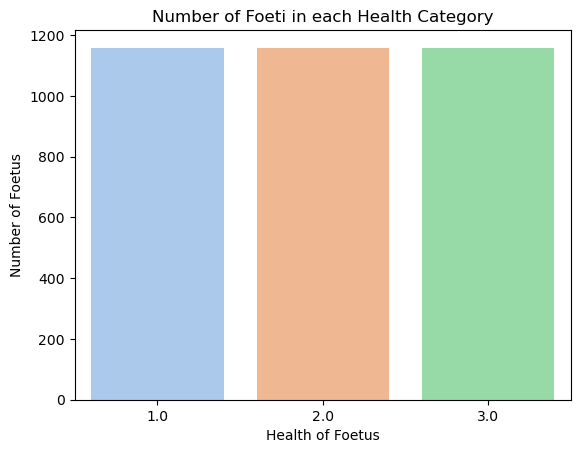

Length of Oversampled Data is 3477
Percentage of Normal Foeti: 33.33%
Percentage of Foeti with Suspected Irregularities: 33.33%
Percentage of Foeti with necessary pathology procedures needed: 33.33%


In [8]:
features = fetal_health_df.loc[:, fetal_health_df.columns != 'fetal_health']
target = fetal_health_df.loc[:, fetal_health_df.columns == 'fetal_health']

smote = SMOTE(random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    train_size = 0.7, 
                                                   random_state = 42)
columns = X_train.columns

os_X, os_y = smote.fit_resample(X_train, y_train)
os_X = pd.DataFrame(os_X, columns = columns)

count_plot = sns.countplot(x = 'fetal_health', data = os_y, palette = 'pastel')
count_plot.set(xlabel = 'Health of Foetus', ylabel = 'Number of Foetus', title = 'Number of Foeti in each Health Category')
plt.show()

print('Length of Oversampled Data is',len(os_X))

def percentage_calc(category_string):
    pct_1 = len(os_y[os_y['fetal_health'] == category_string[0]]) / len(os_y) * 100
    pct_2 = len(os_y[os_y['fetal_health'] == category_string[1]]) / len(os_y) * 100
    pct_3 = len(os_y[os_y['fetal_health'] == category_string[2]]) / len(os_y) * 100
    print(f'Percentage of Normal Foeti: {pct_1:.2f}%')
    print(f'Percentage of Foeti with Suspected Irregularities: {pct_2:.2f}%')
    print(f'Percentage of Foeti with necessary pathology procedures needed: {pct_3:.2f}%')
    
string = [1.0, 2.0, 3.0]    
percentage_calc(string)

#### We have successfully created a balanced dataset! We can carry on with our analysis

### Statistical Analysis

In [9]:
scaler = preprocessing.MinMaxScaler()
scaled_X = scaler.fit_transform(os_X)
scaled_y = scaler.fit_transform(os_y)
logit = sm.Logit(scaled_y, scaled_X)
result = logit.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.314259
         Iterations 9
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.547    
Dependent Variable: y                AIC:              2227.3544
Date:               2023-10-03 20:33 BIC:              2356.5869
No. Observations:   3477             Log-Likelihood:   -1092.7  
Df Model:           20               LL-Null:          -2410.1  
Df Residuals:       3456             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     9.0000                                      
------------------------------------------------------------------
         Coef.    Std.Err.      z      P>|z|     [0.025     0.975]
------------------------------------------------------------------
x1       3.4392     0.9316    3.6919   0.0002     1.6134    5.2650
x2      -8.7969     1.1764   -7.4777   0.0000   -11.1026   -6.4912
x3 

In [8]:
os_X = os_X[['baseline value', 'accelerations', 'fetal_movement', 'uterine_contractions', 'prolongued_decelerations', 
             'abnormal_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'histogram_max', 
             'histogram_number_of_peaks', 'histogram_mode', 'histogram_mean', 'histogram_variance', 'hist_tendency']]

scaled_X = scaler.fit_transform(os_X)
logit = sm.Logit(scaled_y, scaled_X)
result = logit.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.317304
         Iterations 9
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.542    
Dependent Variable: y                AIC:              2232.5348
Date:               2021-11-28 22:04 BIC:              2312.5359
No. Observations:   3477             Log-Likelihood:   -1103.3  
Df Model:           12               LL-Null:          -2410.1  
Df Residuals:       3464             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     9.0000                                      
------------------------------------------------------------------
         Coef.    Std.Err.      z      P>|z|     [0.025     0.975]
------------------------------------------------------------------
x1       3.8629     0.6396    6.0398   0.0000     2.6094    5.1165
x2      -8.9050     1.1153   -7.9846   0.0000   -11.0909   -6.7191
x3 

In [10]:
os_X = os_X[['baseline value', 'accelerations', 'fetal_movement', 'uterine_contractions', 'prolongued_decelerations', 
             'abnormal_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'histogram_max', 
             'histogram_number_of_peaks', 'histogram_mode', 'histogram_variance']]

scaled_X = scaler.fit_transform(os_X)
logit = sm.Logit(scaled_y, scaled_X)
result = logit.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.317338
         Iterations 9
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.542    
Dependent Variable: y                AIC:              2228.7706
Date:               2023-10-03 20:33 BIC:              2296.4638
No. Observations:   3477             Log-Likelihood:   -1103.4  
Df Model:           10               LL-Null:          -2410.1  
Df Residuals:       3466             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     9.0000                                      
------------------------------------------------------------------
        Coef.    Std.Err.      z       P>|z|     [0.025     0.975]
------------------------------------------------------------------
x1      3.6164     0.6085     5.9436   0.0000     2.4239    4.8089
x2     -9.0835     1.1097    -8.1854   0.0000   -11.2585   -6.9085
x3 

##### Observations:

All variables have a p-values less than 0.05 and thus we have the data ready for training the model

### Hyperparameter Tuning

In [11]:
features = os_X[['baseline value', 'accelerations', 'fetal_movement', 'uterine_contractions', 'prolongued_decelerations', 
                 'abnormal_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'histogram_max', 
                 'histogram_number_of_peaks', 'histogram_mode', 'histogram_variance']]
target = os_y
target = target.values.ravel()
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size = 0.7, random_state = 42)

model = LogisticRegression(random_state = 42)
grid = {'penalty': ['l2', 'none'],
        'tol': [0.0001, 0.001, 0.1],
        'max_iter': [10000],
        'solver': ['sag', 'newton-cg'],
        'fit_intercept': [True, False]}

model_grid = GridSearchCV(model, param_grid = grid, scoring = 'accuracy', cv = 2, verbose = 1)
model_grid.fit(X_train, y_train)
print('Best Hyperparamter:', model_grid.best_params_)
print(f'Best Hyperparameter Score: {model_grid.best_score_:.4f}' )

Fitting 2 folds for each of 24 candidates, totalling 48 fits


C:\Users\keebs\Anaconda\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\keebs\Anaconda\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\keebs\Anaconda\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\keebs\Anaconda\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Best Hyperparamter: {'fit_intercept': True, 'max_iter': 10000, 'penalty': 'none', 'solver': 'newton-cg', 'tol': 0.001}
Best Hyperparameter Score: 0.8890


### Classification Model Traning, Predictions & Results

In [12]:
features = os_X[['baseline value', 'accelerations', 'fetal_movement', 'uterine_contractions', 'prolongued_decelerations', 
                 'abnormal_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'histogram_max', 
                 'histogram_number_of_peaks', 'histogram_mode', 'histogram_variance']]
target = os_y
target = target.values.ravel()
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size = 0.7, random_state = 42)

model = LogisticRegression(fit_intercept = True, max_iter = 1e5, penalty = 'none', solver = 'newton-cg',
                           tol = 1e-3, random_state = 42)
model.fit(X_train, y_train)
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
# confusion_matrix = confusion_matrix(y_test, test_predictions)

print(f'Train Accuray: {accuracy_score(y_train, train_predictions) * 100:.2f} %')
print(f'Test Accuray: {accuracy_score(y_test, test_predictions) * 100:.2f} %')
print('')
print('Confusion Matrix')
print('')
print(confusion_matrix)
print('')
print('Classification Report')
print('')
print(classification_report(y_test, test_predictions))

Train Accuray: 89.11 %
Test Accuray: 88.12 %

Confusion Matrix

<function confusion_matrix at 0x000001D8313258B0>

Classification Report

              precision    recall  f1-score   support

         1.0       0.96      0.88      0.92       360
         2.0       0.81      0.86      0.83       341
         3.0       0.88      0.91      0.89       343

    accuracy                           0.88      1044
   macro avg       0.88      0.88      0.88      1044
weighted avg       0.89      0.88      0.88      1044

